# Homework 1 - ML for PP
Felipe Alamos

In [25]:
import requests
import pandas as pd


## Question 1: Data Acquisition and Analysis

In [258]:
crime_2018_url = "https://data.cityofchicago.org/resource/6zsd-86xi.json?year=2018&$limit=300000"#300000"
crime_2017_url = "https://data.cityofchicago.org/resource/6zsd-86xi.json?year=2017&$limit=300000"#300000"

def download_crime_data(year):
  url=''
  if year==2018:
    url=crime_2018_url
  elif year ==2017:
    url=crime_2017_url
  else:
    return False
  return  pd.read_json(url)
  

df_2018 = download_crime_data(2018)
df_2017 = download_crime_data(2017)

print(df_2018)



        arrest  beat                    block case_number  community_area  \
0        False   524      117XX S SANGAMON ST    JB140548            53.0   
1        False  2433    011XX W GRANVILLE AVE    JB108189            77.0   
2        False  2411        025XX W TOUHY AVE    JB108139             2.0   
3        False  1834     004XX N MICHIGAN AVE    JB108319             8.0   
4        False  2223       097XX S HALSTED ST    JB108166            73.0   
5         True  1612       062XX N OLCOTT AVE    JB108167            10.0   
6        False   313          004XX E 63RD ST    JB108191            42.0   
7        False  2222          014XX W 87TH ST    JB108181            71.0   
8        False   726          021XX W 63RD ST    JB108164            67.0   
9        False  1811      010XX W WEBSTER AVE    JB108207             7.0   
10       False  1713     030XX W LAWRENCE AVE    JB107225            14.0   
11       False  1112     007XX N RIDGEWAY AVE    JB108739            23.0   

                                       2017      2018  % change
Type of Crimes                                                 
ARSON                                 444.0     372.0     -16.0
ASSAULT                             19303.0   20377.0       6.0
BATTERY                             49214.0   49782.0       1.0
BURGLARY                            13001.0   11730.0     -10.0
CONCEALED CARRY LICENSE VIOLATION      69.0     149.0     116.0
CRIM SEXUAL ASSAULT                  1628.0    1627.0      -0.0
CRIMINAL DAMAGE                     29042.0   27806.0      -4.0
CRIMINAL TRESPASS                    6812.0    6904.0       1.0
DECEPTIVE PRACTICE                  19028.0   18731.0      -2.0
GAMBLING                              191.0     201.0       5.0
HOMICIDE                              676.0     586.0     -13.0
HUMAN TRAFFICKING                       9.0      14.0      56.0
INTERFERENCE WITH PUBLIC OFFICER     1086.0    1305.0      20.0
INTIMIDATION                          15

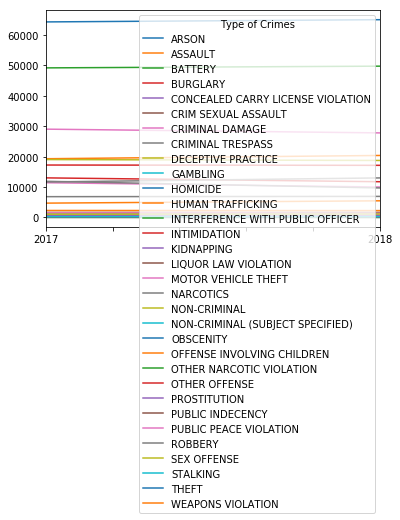

In [262]:

comunities_url ="https://data.cityofchicago.org/resource/igwz-8jzy.json"


def load_comunities():
  return  pd.read_json(comunities_url)




# Generate summary statistics for the crime reports data including but not limited to
# number of crimes of each type, how they change over time, and how they are
# different by neighborhood. Please use a combination of tables and graphs to
# present these summary stats.


#Get frquency of different type of crimes
type_crimes_2018 = pd.DataFrame(df_2018.groupby(['primary_type']).size())
type_crimes_2018.columns = ['2018']

type_crimes_2017 = pd.DataFrame(df_2017.groupby(['primary_type']).size())
type_crimes_2017.columns = ['2017']

#Add two dataframes fill NaN with 0s
freq_table = type_crimes_2018.add(type_crimes_2017, fill_value=0)
freq_table=freq_table.fillna(0)
freq_table.index.names = ['Type of Crimes']


#Add totals
n_of_crimes_2018=df_2018.count()[0]
n_of_crimes_2017=df_2017.count()[0]
freq_table.loc['TOTAL', '2017'] = n_of_crimes_2017
freq_table.loc['TOTAL', '2018'] = n_of_crimes_2018


#Add rate change
freq_table['% change'] = round(freq_table['2018']/freq_table['2017']*100-100)

print(freq_table)

#Creat table for plotting, and plot
freq_table_plot = freq_table[['2017','2018']]
freq_table_plot=freq_table_plot.drop(freq_table_plot.tail(1).index)
print(freq_table_plot)
freq_table_plot.T.plot.line()

In [263]:
#Analysis per neighborhood/community area
crime_per_neighborhood_2018 = pd.DataFrame(df_2018.groupby(['community_area']).size())
crime_per_neighborhood_2018.columns = ['# of crimes']

neighborhoods = load_comunities()
print(neighborhoods)
neighborhoods.index.name = 'id'

#Join between freq table per neigh and table of names of neigh
neighborhoods_table = crime_per_neighborhood_2018.join(neighborhoods, on='community_area')
neighborhoods_table = neighborhoods_table[['# of crimes','community']] #Keep only these 2 columns
neighborhoods_table.columns=['# of crimes','Neighborhood'] #Change columns names

neighborhoods_table['% of total crimes in city'] = neighborhoods_table['# of crimes']/n_of_crimes_2018*100


print(neighborhoods_table.sort_values('# of crimes',ascending=False))

#POSSIBLY HERE TO INCLUDE HEAT MAP

    area  area_num_1  area_numbe  comarea  comarea_id               community  \
0      0          35          35        0           0                 DOUGLAS   
1      0          36          36        0           0                 OAKLAND   
2      0          37          37        0           0             FULLER PARK   
3      0          38          38        0           0         GRAND BOULEVARD   
4      0          39          39        0           0                 KENWOOD   
5      0           4           4        0           0          LINCOLN SQUARE   
6      0          40          40        0           0         WASHINGTON PARK   
7      0          41          41        0           0               HYDE PARK   
8      0          42          42        0           0                WOODLAWN   
9      0           1           1        0           0             ROGERS PARK   
10     0          11          11        0           0          JEFFERSON PARK   
11     0          12        

                # of crimes            Neighborhood  % of total crimes in city
community_area                                                                
25.0                  15043                  AUSTIN                   5.649486
8.0                   13056                WOODLAWN                   4.903257
32.0                  10856         LOWER WEST SIDE                   4.077034
28.0                   9399          NEAR WEST SIDE                   3.529849
29.0                   9311          NORTH LAWNDALE                   3.496800
43.0                   8648           MCKINLEY PARK                   3.247807
23.0                   8039           HUMBOLDT PARK                   3.019093
71.0                   7370      WASHINGTON HEIGHTS                   2.767846
24.0                   7301               WEST TOWN                   2.741933
67.0                   7066            LINCOLN PARK                   2.653677
49.0                   6885           SOUTH DEERING 

## Question 2: Data Augmentation and APIs

In [281]:
def get_block_id(lat,lon):
  block_request_url = 'https://geo.fcc.gov/api/census/block/find?latitude='+str(lat)+'&longitude='+str(lon)+'&format=json'
  return  pd.read_json(block_request_url)

# print(get_block_id(41.801270,-87.598630))

key = '72e403f3a8aeb7ae9d1c95fe84f9908388b565cf'

# median_hosuelod_income ='B19013_001E'
# poverty_p = 'DP03_0119PE,'
# af_am_p = 'DP05_0033PE,'
# less_than_50p = 'DP04_0081PE'
variables='B01001_001E,NAME'
key = '5984786462aaccc39f904bf750cc8274bd40f9f8'
url = 'https://api.census.gov/data/2017/acs/acs5?get='+variables+'&for=block%20group:*&in=state:17%40county:031&key='+key

# url = 'https://api.census.gov/data/2015/acs5/profile?get=NAME,'+ poverty_p + af_am_p + less_than_50p + '&for=tract:*&in=state:17+county:031
data = pd.read_json(url)

data.columns = data.iloc[0] #Move first row to header
data = data.iloc[1:] #Remove first row

data

#crimes tiene block, social tiene block group y track


,B01001_001E,NAME,state,county,tract,block group
1,600,"Block Group 1, Census Tract 2519, Cook County,...",17,031,251900,1
2,1546,"Block Group 2, Census Tract 2519, Cook County,...",17,031,251900,2
3,1341,"Block Group 1, Census Tract 8211.01, Cook Coun...",17,031,821101,1
4,1356,"Block Group 3, Census Tract 8211.01, Cook Coun...",17,031,821101,3
5,616,"Block Group 2, Census Tract 8211.01, Cook Coun...",17,031,821101,2
6,1193,"Block Group 4, Census Tract 8211.01, Cook Coun...",17,031,821101,4
7,2054,"Block Group 1, Census Tract 8202.02, Cook Coun...",17,031,820202,1
8,558,"Block Group 3, Census Tract 8202.02, Cook Coun...",17,031,820202,3
9,752,"Block Group 2, Census Tract 8202.02, Cook Coun...",17,031,820202,2
10,1700,"Block Group 4, Census Tract 8203, Cook County,...",17,031,820300,4


## Question 4: 911

a)

In [265]:
import censusgeocode as cg


#PENDING. From address to comunity area
# 2111 S Michigan Ave is is Near South Side Neighborhood
#Look at different types of crimes in thaat community area
# 33                        2         NEAR SOUTH SIDE
# address="

crimes_33 = df_2018.loc[df_2018['community_area'] == 33]

type_crimes_33 = pd.DataFrame(crimes_33.groupby(['primary_type']).size())
type_crimes_33.columns = ['# of crimes']
type_crimes_33.index.names = ['Type of Crimes']
type_crimes_33=type_crimes_33.sort_values('# of crimes', ascending=False)

#
total_33 = type_crimes_33['# of crimes'].sum()


type_crimes_33['Fraction of total']=type_crimes_33['# of crimes']/total_33
# freq_table.loc['TOTAL', '2017'] = n_of_crimes_2017


print(type_crimes_33)




                                   # of crimes  Fraction of total
Type of Crimes                                                   
THEFT                                      591           0.318598
BATTERY                                    289           0.155795
DECEPTIVE PRACTICE                         261           0.140701
CRIMINAL DAMAGE                            190           0.102426
ASSAULT                                    122           0.065768
OTHER OFFENSE                              111           0.059838
MOTOR VEHICLE THEFT                         71           0.038275
CRIMINAL TRESPASS                           53           0.028571
ROBBERY                                     49           0.026415
BURGLARY                                    32           0.017251
NARCOTICS                                   19           0.010243
WEAPONS VIOLATION                           12           0.006469
CRIM SEXUAL ASSAULT                         12           0.006469
PUBLIC PEA

Given the data of crimes in 2018, and the crime types in NEAR SOUTH SIDE, it is most likely that the type of crime related to the call is a Theft. The 'Fraction of total' in the previous table is a good aproximation to the probabilities of each type of request.

b)

In [266]:
# Let’s now assume that a call comes in about Theft. Which is more likely – that the
# call came from Garfield Park or Uptown? How much more or less likely is it to be
# from Garfield Park vs Uptown?

#First filter crimes so as only to have thefts
thefts = df_2018.loc[df_2018['primary_type'] == 'THEFT']

#Group by community_areas
thefts = pd.DataFrame(thefts.groupby(['community_area']).size())
thefts.columns = ['# of thefts']


#Join with neighborhoods info to get names of community_areas
thefts_neighborhoods = thefts.join(neighborhoods, on='community_area')
thefts_neighborhoods = thefts_neighborhoods[['# of thefts','community']] #Keep only these 2 columns
thefts_neighborhoods.columns=['# of thefts','Neighborhood'] #Change columns names

#Filter neighborhoods
some_neighbors=['WEST GARFIELD PARK','EAST GARFIELD PARK','UPTOWN']
crimes_uptown_or_garfield=thefts_neighborhoods.loc[thefts_neighborhoods['Neighborhood'].isin(some_neighbors)]
crimes_uptown_or_garfield = crimes_uptown_or_garfield.reset_index()

#Drop community_area code column
crimes_uptown_or_garfield = crimes_uptown_or_garfield.drop(['community_area'], axis=1)

total_garfield = crimes_uptown_or_garfield.loc[0]['# of thefts'] + crimes_uptown_or_garfield.loc[1]['# of thefts']

#Create new row with total for Garfield
crimes_uptown_or_garfield = crimes_uptown_or_garfield.append({'# of thefts' : total_garfield , 'Neighborhood' : 'GARFIELD'} , ignore_index=True)


#Delete previous garfield rows
final_neighbors=['GARFIELD','UPTOWN']
crimes_uptown_or_garfield=crimes_uptown_or_garfield.loc[crimes_uptown_or_garfield['Neighborhood'].isin(final_neighbors)]

# crimes_uptown_or_garfield = crimes_uptown_or_garfield[['Neighborhood', '# of thefts']]
print(crimes_uptown_or_garfield)


   # of thefts Neighborhood
2          795       UPTOWN
3         1333     GARFIELD


Considering the amounts of thefts that occured in 2019, we can observe that it is more likely that a new theft will occur in Garfield rather than in Uptown. The following number representes how much more likely is it the theft to be from Garfield Park vs Uptown:

In [267]:
change_likelihood=crimes_uptown_or_garfield.iloc[1]['# of thefts']/crimes_uptown_or_garfield.iloc[0]['# of thefts']-1
print(str(change_likelihood*100)+'%')


67.67295597484278%
